# Analisis Data Menggunakan MongoDB: Pengenalan Aggregation

Analisis atau pemrosesan data umumnya menggunakan looping (for, while). Lopping ini biasanya dilakukan berlapis-lapis mengikuti dimensi data yang ingin dianalisis atau diproses. Contoh, diketahui sebuah matriks seperti di bawah ini:

In [2]:
import numpy as np

a = np.zeros((5,5))
a[3,3] = 100
a[2,1] = 67
a

array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.],
       [  0.,  67.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0.,   0.,   0.]])

Jika kita ingin mengubah nilai yang lebih dari 0 (>0) pada matriks a di atas menjadi -1, maka pendekatan yang biasanya dilakukan adalah dengan 2 looping berlapis seperti dibawah ini.

In [4]:
for i in range(len(a)):
    for j in range(len(a[0])):
        if a[i,j] > 0:
            a[i,j] = -1
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

Semakin banyak dimensi data suatu matriks, lamanya processing suatu script atau program akan semakin bertambah secara eksponensial (mengacu kepada big O, perhitungan kompleksitas suatu program). Oleh karena itu, sebisa mungkin dalam script yang kita bangun, hindari sebisa mungkin untuk meminimalkan menggunakan looping apalagi looping berlapis. Meniadakan penggunaan looping sama sekali itu tidak mungkin terkadang. Pada contoh diatas, kita bisa mengeliminasi penggunaan 2 looping berlapis menjadi tanpa looping sama sekali dengan:

In [3]:
a = np.zeros((5,5))
a[3,3] = 100
a[2,1] = 67
a

a[a>0] = -1
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

Fenomena inilah alasan kita menggunakan aggregation untuk analisis data di MongoDB. Aggregation atau aggregation pipeline pada MongoDB adalah serangkaian processing yang dilakukan MongoDB dan menghasilkan dokumen-dokumen dalam bentuk yang baru. Contoh kita ingin mencari suhu rata-rata harian di bulan Januari di Bandara Makassar:

Pertama akses dulu collection yang kita inginkan

In [5]:
import pymongo

client = pymongo.MongoClient()
collection = client['meteo_achieve']['metar_param']

Lalu lakukan operasi aggregation

In [32]:
#mencari suhu rata-rata harian pada bulan Januari
pipeline = [{"$match" : {"stasiun" : "WAAA", "bulan" : 1, "suhu" : {"$ne" : "NO DATA"}}},
{"$group" : {"_id": "$hari", "rata-rata": {"$avg" : "$suhu"}}},
{"$sort" : {"_id" : 1}}]
hasil = list(collection.aggregate(pipeline))

print(hasil)

[{'rata-rata': 26.446194225721786, '_id': 1}, {'rata-rata': 26.783375314861463, '_id': 2}, {'rata-rata': 26.71645569620253, '_id': 3}, {'rata-rata': 26.295739348370926, '_id': 4}, {'rata-rata': 26.452926208651398, '_id': 5}, {'rata-rata': 26.715425531914892, '_id': 6}, {'rata-rata': 26.95959595959596, '_id': 7}, {'rata-rata': 27.06153846153846, '_id': 8}, {'rata-rata': 27.027918781725887, '_id': 9}, {'rata-rata': 27.002590673575128, '_id': 10}, {'rata-rata': 26.89769820971867, '_id': 11}, {'rata-rata': 26.268571428571427, '_id': 12}, {'rata-rata': 26.761517615176153, '_id': 13}, {'rata-rata': 26.39782016348774, '_id': 14}, {'rata-rata': 25.764383561643836, '_id': 15}, {'rata-rata': 25.626038781163434, '_id': 16}, {'rata-rata': 26.5243553008596, '_id': 17}, {'rata-rata': 27.191637630662022, '_id': 18}, {'rata-rata': 26.072340425531916, '_id': 19}, {'rata-rata': 26.045226130653266, '_id': 20}, {'rata-rata': 26.714975845410628, '_id': 21}, {'rata-rata': 26.92452830188679, '_id': 22}, {'ra

Kompleksitas O(n). Lalu kita coba plot hasilnya

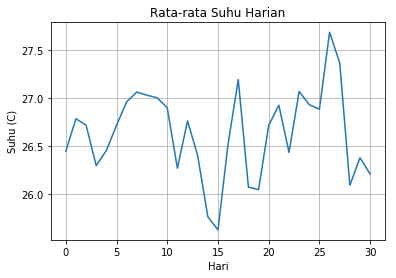

In [20]:
#plot data
waktu_suhu = []
data_suhu = []
for i in range(len(hasil)):
	data_suhu.append(hasil[i]['rata-rata'])
waktu_suhu = np.arange(len(data_suhu))


from matplotlib import pyplot as plt

plt.plot(waktu_suhu, data_suhu)
plt.xlabel('Hari')
plt.ylabel('Suhu (C)')
plt.title('Rata-rata Suhu Harian')
plt.grid(True)

plt.show()

Jika kita tidak menggunakan aggregation, maka pendekatan yang sangat sederhana dan biasa kita gunakan kira-kira seperti ini:

In [33]:
all_WAAA_1bulan = list(collection.find({'stasiun' : 'WAAA', 'bulan' : 1, 'suhu' : {'$ne' : 'NO DATA'}}))
hasil = []
for j in range(1,32):
    cnt = []
    for i in range(len(all_WAAA_1bulan)):
        if all_WAAA_1bulan[i]['hari'] == j:
            cnt.append(all_WAAA_1bulan[i]['suhu'])
    cnt = np.asarray(cnt)
    hasil.append([j,np.mean(cnt)])
print(hasil)

[[1, 26.446194225721786], [2, 26.783375314861463], [3, 26.71645569620253], [4, 26.295739348370926], [5, 26.452926208651398], [6, 26.715425531914892], [7, 26.95959595959596], [8, 27.06153846153846], [9, 27.027918781725887], [10, 27.002590673575128], [11, 26.89769820971867], [12, 26.268571428571427], [13, 26.761517615176153], [14, 26.39782016348774], [15, 25.764383561643836], [16, 25.626038781163434], [17, 26.5243553008596], [18, 27.191637630662022], [19, 26.072340425531916], [20, 26.045226130653266], [21, 26.714975845410628], [22, 26.92452830188679], [23, 26.43362831858407], [24, 27.067357512953368], [25, 26.92972972972973], [26, 26.88268156424581], [27, 27.68421052631579], [28, 27.365269461077844], [29, 26.091428571428573], [30, 26.377450980392158], [31, 26.207792207792206]]


Hasilnya sama, tapi kompleksitasnya O(n^2), kurang efisien. Jika jumlah data yang di proses semakin besar, perbedaan performanya akan semakin terlihat antara O(n) dan O(N^2).

Contoh lagi, penggunaan aggregation untuk mencari rata-rata suhu harian lagi tapi untuk seluruh hari dalam setahun:

In [38]:
#mencari suhu rata-rata harian setiap bulan per hari
pipeline = [{"$match" : {"stasiun" : "WAAA", "suhu" : {"$ne" : "NO DATA"}}},
{"$group" : {"_id": {"bulan" : "$bulan", "hari" : "$hari"}, "rata-rata": {"$avg" : "$suhu"}}},
{"$sort" : {"_id" : 1}}]
hasil = list(collection.aggregate(pipeline))

Lalu plot

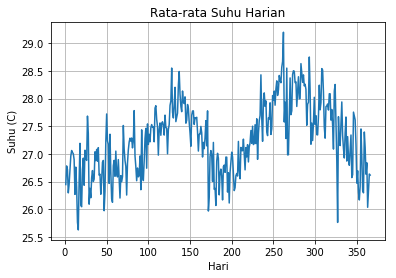

In [39]:
data_suhu = []
for i in range(len(hasil)):
	data_suhu.append(hasil[i]['rata-rata'])
data_suhu = np.asarray(data_suhu)
waktu_suhu = np.arange(len(data_suhu))
waktu_suhu += 1

plt.plot(waktu_suhu, data_suhu)
plt.xlabel('Hari')
plt.ylabel('Suhu (C)')
plt.title('Rata-rata Suhu Harian')
plt.grid(True)

plt.show()

Kompleksitas script menggunakan aggregation untuk kasus kedua ini masih sama, yaitu O(n). Kalau kita tidak menggunakan aggregation, maka untuk kasus ini kompleksitas script kita akan meningkat menjadi O(n^3) dibandingkan kasus sebelumnya yang mirip.

Contoh lain lagi, menghitung rata-rata terjadinya angin variabel per bulan yang terjadi di bandara Makassar.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] [459.8888888888889, 478.875, 488.55555555555554, 458.8888888888889, 402.0, 311.77777777777777, 341.6666666666667, 420.55555555555554, 397.1111111111111, 389.375, 411.25, 466.75]


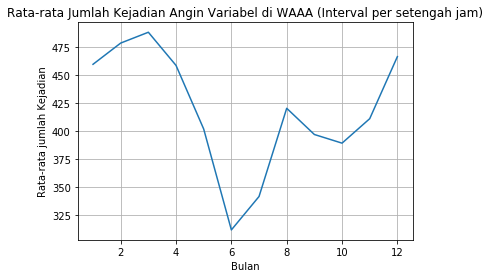

In [40]:
#menghitung rata-rata banyaknya angin variabel per bulan
pipeline = [{"$match" : {"stasiun" : "WAAA", "arah_angin_var1" : {"$ne" : "NO DATA"}}},
{"$group" : {"_id": {"tahun" : "$tahun", "bulan" : "$bulan"}, "total_angin_var": {"$sum" : 1}}},
{"$group" : {"_id": {"bulan" : "$_id.bulan"}, "rata_angin_var": {"$avg" : "$total_angin_var"}}},
{"$sort" : {"_id" : 1}}]
hasil = list(collection.aggregate(pipeline))
waktu = []
data = []
for i in range(len(hasil)):
	waktu.append(hasil[i]['_id']['bulan'])
	data.append(hasil[i]['rata_angin_var'])
print(waktu, data)

plt.plot(np.asarray(waktu), np.asarray(data))
plt.xlabel('Bulan')
plt.ylabel('Rata-rata jumlah Kejadian')
plt.title('Rata-rata Jumlah Kejadian Angin Variabel di WAAA (Interval per setengah jam)')
plt.grid(True)

plt.show()